In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

In [29]:
# Load dataset
df = pd.read_csv("student_dataset.csv")

# Display first few rows
df.head()



,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent
0,2015-05-28 11:15:16,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,tablet,0
1,2015-04-03 03:39:44,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,tablet,1
2,2015-08-31 23:01:21,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,mobile,0
3,2024-03-10 17:02:40,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,tablet,0
4,2024-03-30 08:15:29,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,mobile,0


In [30]:
# Check dataset info (column names, data types, non-null counts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Transaction.Date    240000 non-null  object 
 1   Transaction.Amount  240000 non-null  float64
 2   Customer.Age        240000 non-null  int64  
 3   Account.Age.Days    240000 non-null  int64  
 4   Transaction.Hour    240000 non-null  int64  
 5   source              240000 non-null  object 
 6   browser             240000 non-null  object 
 7   Payment.Method      240000 non-null  object 
 8   Product.Category    240000 non-null  object 
 9   Quantity            240000 non-null  int64  
 10  Device.Used         240000 non-null  object 
 11  Is.Fraudulent       240000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 22.0+ MB


In [31]:
# Count missing values per column
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [32]:
# Get summary statistics for numerical columns
df.describe()

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,Quantity,Is.Fraudulent
count,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000
mean,132.143547,33.834617,117.843075,11.414671,3.005296,0.072008
std,213.518929,9.393592,100.604279,6.947764,1.415310,0.258502
min,9.000000,-8.000000,0.000000,0.000000,1.000000,0.000000
25%,30.000000,27.000000,40.000000,5.000000,2.000000,0.000000
50%,53.000000,33.000000,87.000000,11.000000,3.000000,0.000000
75%,152.740000,40.000000,178.000000,17.000000,4.000000,0.000000
max,8329.900000,79.000000,365.000000,23.000000,5.000000,1.000000


In [33]:
# Display first few rows
df.head()

,Transaction.Date,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent
0,2015-05-28 11:15:16,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,tablet,0
1,2015-04-03 03:39:44,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,tablet,1
2,2015-08-31 23:01:21,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,mobile,0
3,2024-03-10 17:02:40,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,tablet,0
4,2024-03-30 08:15:29,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,mobile,0


In [34]:
# Step 1: Convert 'Transaction.Date' to datetime
df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], errors='coerce')

# Step 2: Extract useful time-based features
df['Transaction.Year'] = df['Transaction.Date'].dt.year
df['Transaction.Month'] = df['Transaction.Date'].dt.month
df['Transaction.Day'] = df['Transaction.Date'].dt.day

In [35]:
# Step 3: Drop original 'Transaction.Date' column (only if needed for modeling)
df.drop(columns=['Transaction.Date'], inplace=True)

In [36]:
# Display first few rows
df.head()

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent,Transaction.Year,Transaction.Month,Transaction.Day
0,45.00,37,35,11,Ads,Chrome,PayPal,electronics,5,tablet,0,2015.0,5.0,28.0
1,15.00,33,44,3,Direct,FireFox,debit card,health & beauty,5,tablet,1,2015.0,4.0,3.0
2,54.00,19,44,23,SEO,Opera,debit card,health & beauty,1,mobile,0,2015.0,8.0,31.0
3,234.42,23,107,17,Ads,Chrome,bank transfer,electronics,5,tablet,0,2024.0,3.0,10.0
4,412.49,23,220,8,Ads,Safari,bank transfer,toys & games,4,mobile,0,2024.0,3.0,30.0


In [37]:
# Step 2: Data Preprocessing - Handling Negative Customer Age Values
positive_mean_age = int(df[df['Customer.Age'] >= 0]['Customer.Age'].mean())  # Convert to integer

# Replace negative ages with the integer mean
df.loc[df['Customer.Age'] < 0, 'Customer.Age'] = positive_mean_age

# Verify if negative ages are handled
print("Customer Age statistics after correction:")
print(df['Customer.Age'].describe())

# Confirm no negative ages remain
print("Negative ages remaining:", df[df['Customer.Age'] < 0].shape[0])

Customer Age statistics after correction:
count    240000.000000
mean         33.837750
std           9.387322
min           0.000000
25%          27.000000
50%          33.000000
75%          40.000000
max          79.000000
Name: Customer.Age, dtype: float64
Negative ages remaining: 0


In [38]:
df.describe()

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,Quantity,Is.Fraudulent,Transaction.Year,Transaction.Month,Transaction.Day
count,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,239998.000000,239998.000000,239998.000000
mean,132.143547,33.837750,117.843075,11.414671,3.005296,0.072008,2019.503300,4.027571,15.310744
std,213.518929,9.387322,100.604279,6.947764,1.415310,0.258502,4.500008,2.802462,8.883245
min,9.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2015.000000,1.000000,1.000000
25%,30.000000,27.000000,40.000000,5.000000,2.000000,0.000000,2015.000000,2.000000,8.000000
50%,53.000000,33.000000,87.000000,11.000000,3.000000,0.000000,2024.000000,3.000000,15.000000
75%,152.740000,40.000000,178.000000,17.000000,4.000000,0.000000,2024.000000,6.000000,23.000000
max,8329.900000,79.000000,365.000000,23.000000,5.000000,1.000000,2024.000000,12.000000,31.000000


In [39]:
# Assuming 'data' is your encoded dataframe from the previous step
# Categorize 'Transaction.Amount' into low, medium, high
df['Amount.Category'] = pd.qcut(df['Transaction.Amount'], q=3, labels=['Low', 'Medium', 'High'])

# Group by 'Amount_Category' and count fraudulent transactions
fraud_counts = df.groupby('Amount.Category')['Is.Fraudulent'].sum().reset_index()

# Display the results
print(fraud_counts)

  Amount.Category  Is.Fraudulent
0             Low           6663
1          Medium           5905
2            High           4714


C:\Users\hp\AppData\Local\Temp\ipykernel_16088\3295259882.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [42]:
# Transaction Amount By Transaction Hours

fig_box_amount = px.box(df, x='Transaction.Hour', y='Transaction.Amount', title='Transaction Amount by Transaction Hour')
fig_box_amount.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [16]:
#Distribution of transaction amount
fig_amount = px.histogram(df, x='Transaction.Amount', nbins=50, title='Distribution of Transaction Amount')
fig_amount.show()

AttributeError: 'Figure' object has no attribute 'histogram'

In [43]:
print(df['Transaction.Amount'].describe())

count    240000.000000
mean        132.143547
std         213.518929
min           9.000000
25%          30.000000
50%          53.000000
75%         152.740000
max        8329.900000
Name: Transaction.Amount, dtype: float64


In [44]:
import plotly.express as px

In [45]:
#CALCULATE MEAN AND STANDARD DAVIATION OF TRANSACTION AMOUNT AND DEFINE ANOMALY THRESHHOLD

mean_amount = df['Transaction.Amount'].mean()
std_amount = df['Transaction.Amount'].std()
anomaly_threshold = mean_amount + 4 * std_amount

#flag anomalies

df['is_anomaly']= df['Transaction.Amount']> anomaly_threshold

#scatterplot of transaction amount with anomalies highlighted

fig_anomalies = px.scatter(df, x='Transaction.Amount', y='Is.Fraudulent', color='is_anomaly', title='Transaction Amount with Anomalies')


fig_anomalies.update_traces(marker=dict(size=12),selector=dict(mode='markers',marker_size =1), opacity=0.7)
fig_anomalies.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [46]:
#Transcation amount vs age
fig_scatter = px.scatter(df, x='Customer.Age', y='Transaction.Amount', color='Is.Fraudulent', title='Transaction Amount vs Age')
fig_scatter.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

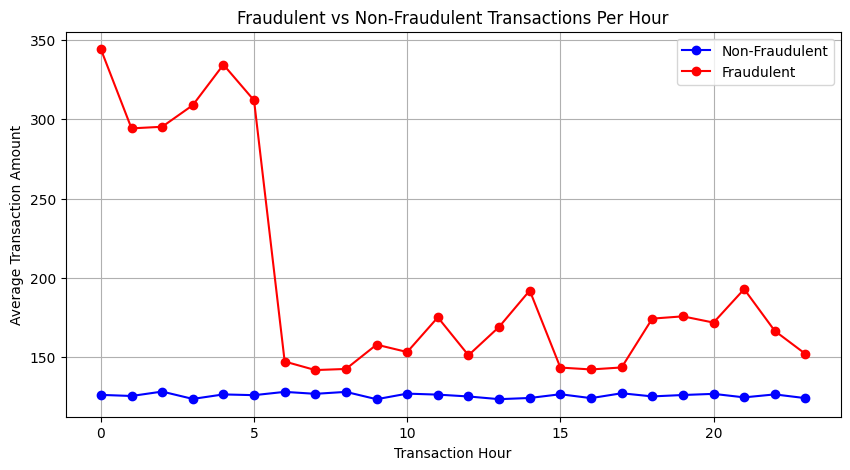

In [47]:
import matplotlib.pyplot as plt


# Group data by Transaction Hour and Is.Fraudulent, then calculate the mean transaction amount
df_grouped = df.groupby(['Transaction.Hour', 'Is.Fraudulent'])['Transaction.Amount'].mean().unstack()

# Plot the line chart
plt.figure(figsize=(10, 5))

# Plot non-fraudulent transactions
plt.plot(df_grouped.index, df_grouped[0], marker='o', linestyle='-', color='b', label='Non-Fraudulent')

# Plot fraudulent transactions
plt.plot(df_grouped.index, df_grouped[1], marker='o', linestyle='-', color='r', label='Fraudulent')

# Add labels and title
plt.xlabel('Transaction Hour')
plt.ylabel('Average Transaction Amount')
plt.title('Fraudulent vs Non-Fraudulent Transactions Per Hour')
plt.legend()
plt.grid(True)

# Show plot
plt.show()



C:\Users\hp\AppData\Local\Temp\ipykernel_16088\1266770031.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



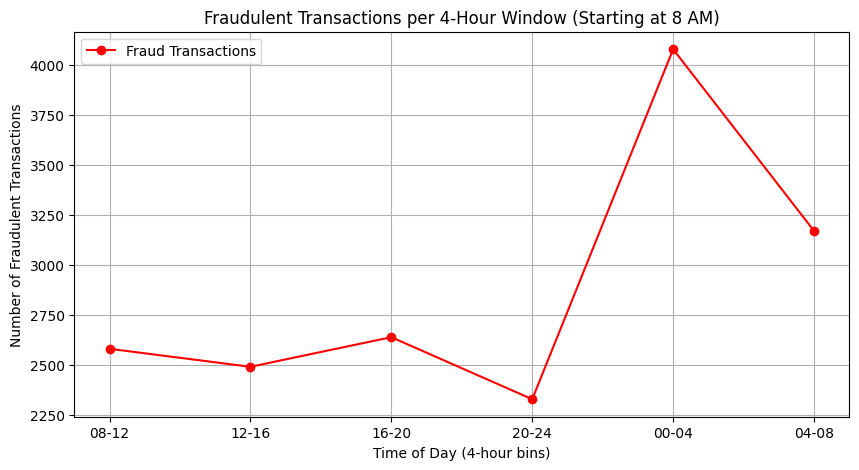

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Define new time bins (starting from 8 AM, rolling over midnight)
bins = [8, 12, 16, 20, 24, 4, 8]  # Adjusted to start from 8 AM
labels = ["08-12", "12-16", "16-20", "20-24", "00-04", "04-08"]

# Assign each transaction to a time bin (handling rollover with modulo)
df['Adjusted_Hour'] = df['Transaction.Hour'].apply(lambda x: x if x >= 8 else x + 24)  # Shift early hours
df['Time_Bin'] = pd.cut(df['Adjusted_Hour'], bins=[8, 12, 16, 20, 24, 28, 32], labels=labels, right=False)

# Filter fraudulent transactions
df_fraud = df[df['Is.Fraudulent'] == 1]

# Count fraudulent transactions per time bin
fraud_counts = df_fraud.groupby('Time_Bin')['Transaction.Amount'].count()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(fraud_counts.index, fraud_counts.values, marker='o', linestyle='-', color='r', label='Fraud Transactions')

# Add labels and title
plt.xlabel('Time of Day (4-hour bins)')
plt.ylabel('Number of Fraudulent Transactions')
plt.title('Fraudulent Transactions per 4-Hour Window (Starting at 8 AM)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [22]:
# Step 3: Handling Outliers in Transaction.Amount using IQR

Q1 = df['Transaction.Amount'].quantile(0.25)  # First quartile (25%)
Q3 = df['Transaction.Amount'].quantile(0.75)  # Third quartile (75%)
IQR = Q3 - Q1  # Interquartile range

# Define limits for valid transaction amounts
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only transactions within the valid range
df = df[(df['Transaction.Amount'] >= lower_bound) & (df['Transaction.Amount'] <= upper_bound)]

# Check updated statistics
print("Transaction Amount statistics after outlier removal:")
print(df['Transaction.Amount'].describe())

Transaction Amount statistics after outlier removal:
count    215146.000000
mean         78.607629
std          76.398373
min           9.000000
25%          28.000000
50%          47.120000
75%          97.630000
max         336.850000
Name: Transaction.Amount, dtype: float64


In [23]:
# Step 4: Normalize Transaction.Amount & Account.Age.Days
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = ['Transaction.Amount', 'Account.Age.Days']

# Use .loc[:] to explicitly modify the DataFrame
df.loc[:, numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check scaled values
print("Scaled Transaction Amount statistics:")
print(df['Transaction.Amount'].describe())
print("\nScaled Account Age statistics:")
print(df['Account.Age.Days'].describe())

Scaled Transaction Amount statistics:
count    215146.000000
mean          0.212315
std           0.233028
min           0.000000
25%           0.057953
50%           0.116273
75%           0.270337
max           1.000000
Name: Transaction.Amount, dtype: float64

Scaled Account Age statistics:
count    215146.000000
mean          0.304549
std           0.266995
min           0.000000
25%           0.104110
50%           0.227397
75%           0.424658
max           1.000000
Name: Account.Age.Days, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_16088\17482407.py:8: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.09589041 0.12054795 0.12054795 ... 0.70684932 0.1260274  0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [ ]:
# Display first few rows
df.head()

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent,Transaction.Year,Transaction.Month,Transaction.Day
0,0.109806,37,0.095890,11,Ads,Chrome,PayPal,electronics,5,tablet,0,2015.0,5.0,28.0
1,0.018301,33,0.120548,3,Direct,FireFox,debit card,health & beauty,5,tablet,1,2015.0,4.0,3.0
2,0.137258,19,0.120548,23,SEO,Opera,debit card,health & beauty,1,mobile,0,2015.0,8.0,31.0
3,0.687571,23,0.293151,17,Ads,Chrome,bank transfer,electronics,5,tablet,0,2024.0,3.0,10.0
5,0.167760,34,0.030137,22,Ads,Chrome,bank transfer,health & beauty,5,tablet,0,2015.0,3.0,22.0


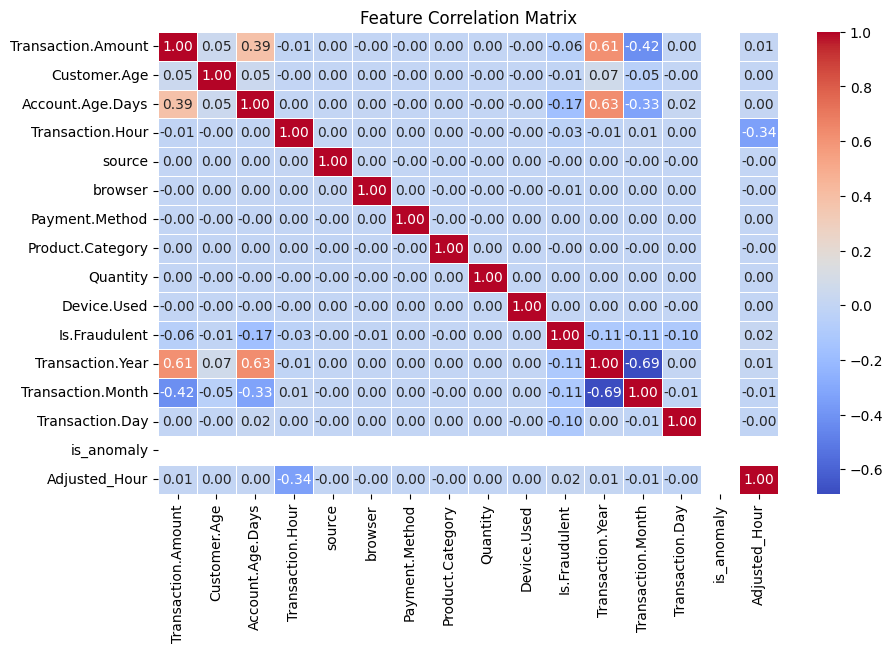

In [24]:


# Ensure all categorical variables are encoded before computing correlation
from sklearn.preprocessing import LabelEncoder


# Identify categorical columns and apply Label Encoding
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Compute correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr(numeric_only=True)  # Ensuring only numeric columns

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
# Display first few rows
df.head()

,Transaction.Amount,Customer.Age,Account.Age.Days,Transaction.Hour,source,browser,Payment.Method,Product.Category,Quantity,Device.Used,Is.Fraudulent,Transaction.Year,Transaction.Month,Transaction.Day
0,0.109806,37,0.095890,11,0,0,0,1,5,2,0,2015.0,5.0,28.0
1,0.018301,33,0.120548,3,1,1,3,2,5,2,1,2015.0,4.0,3.0
2,0.137258,19,0.120548,23,2,3,3,2,1,1,0,2015.0,8.0,31.0
3,0.687571,23,0.293151,17,0,0,1,1,5,2,0,2024.0,3.0,10.0
5,0.167760,34,0.030137,22,0,0,1,2,5,2,0,2015.0,3.0,22.0


In [26]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Ensure df is defined
if 'df' not in globals():
    raise ValueError("Dataset (df) is not defined. Load or preprocess it before applying SMOTE.")

# Step 1: Define Features (X) and Target (y)
X = df.drop(columns=['Is.Fraudulent'], errors='ignore')  # Features
y = df['Is.Fraudulent']  # Target variable

# Step 2: Convert all columns to numeric (to avoid dtype issues)
X = X.apply(pd.to_numeric, errors='coerce')

# Step 3: Double-check and replace any NaN or infinite values before SMOTE
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
X.fillna(X.mean(), inplace=True)  # Fill NaNs with column mean

# Step 4: Apply SMOTE (Synthetic Minority Oversampling)
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Increase fraud cases to 50% of non-fraud
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Convert back to DataFrame for compatibility
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced['Is.Fraudulent'] = y_resampled  # Add target column back

# Step 6: Check class distribution after balancing
print("\nClass Distribution After Balancing:")
print(df_balanced['Is.Fraudulent'].value_counts(normalize=True))

# Step 7: Verify if `df_balanced` is correctly defined
print("\ndf_balanced Shape:", df_balanced.shape)


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Ensure df_balanced is properly defined
if 'df_balanced' not in globals():
    df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
    df_balanced['Is.Fraudulent'] = y_resampled  # Add target column back

# Verify class distribution before proceeding
print("Class Distribution in df_balanced:")
print(df_balanced['Is.Fraudulent'].value_counts(normalize=True))


Class Distribution in df_balanced:
Is.Fraudulent
0    0.666668
1    0.333332
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Importing imputer to handle NaNs
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Step 1: Define Features (X) and Target (y)
X = df.drop(columns=['Is.Fraudulent'])  # Features
y = df['Is.Fraudulent']  # Target variable

# Step 2: Manual Oversampling (Duplicate Fraud Cases)
fraud_cases = df[df['Is.Fraudulent'] == 1]
non_fraud_cases = df[df['Is.Fraudulent'] == 0]

# Oversample fraud cases (duplicate until they reach 50% of non-fraud cases)
fraud_oversampled = fraud_cases.sample(n=len(non_fraud_cases) // 2, replace=True, random_state=42)

# Combine dataset
df_balanced = pd.concat([non_fraud_cases, fraud_oversampled], axis=0).sample(frac=1, random_state=42)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.drop(columns=['Is.Fraudulent']), df_balanced['Is.Fraudulent'],
    test_size=0.2, stratify=df_balanced['Is.Fraudulent'], random_state=42
)

# Step 4: Handle Missing Values Before Scaling
imputer = SimpleImputer(strategy="mean")  # Replace NaN with column mean
X_train_imputed = imputer.fit_transform(X_train)  # Fit & transform training data
X_test_imputed = imputer.transform(X_test)  # Transform test data

# Step 5: Apply Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Step 6: Model Training & Evaluation
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and Evaluate Models
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for ROC-AUC

    # Compute Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Store Results
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'ROC-AUC': roc_auc}

    # Print Classification Report
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))
    print('-' * 40)

# Display Evaluation Metrics
import ace_tools as tools
evaluation_df = pd.DataFrame(results).T
tools.display_dataframe_to_user(name="Updated Model Evaluation Metrics", dataframe=evaluation_df)

print("\nStep 6 (Train-Test Split) and Step 7 (Model Training & Evaluation) are complete.")


ValueError: Cannot cast object dtype to float64

Dataset Preview:
      Transaction.Date  Transaction.Amount  Customer.Age  Account.Age.Days  \
0  2015-05-28 11:15:16               45.00            37                35   
1  2015-04-03 03:39:44               15.00            33                44   
2  2015-08-31 23:01:21               54.00            19                44   
3  2024-03-10 17:02:40              234.42            23               107   
4  2024-03-30 08:15:29              412.49            23               220   

   Transaction.Hour  source  browser Payment.Method Product.Category  \
0                11     Ads   Chrome         PayPal      electronics   
1                 3  Direct  FireFox     debit card  health & beauty   
2                23     SEO    Opera     debit card  health & beauty   
3                17     Ads   Chrome  bank transfer      electronics   
4                 8     Ads   Safari  bank transfer     toys & games   

   Quantity Device.Used  Is.Fraudulent  
0         5      tablet              0  

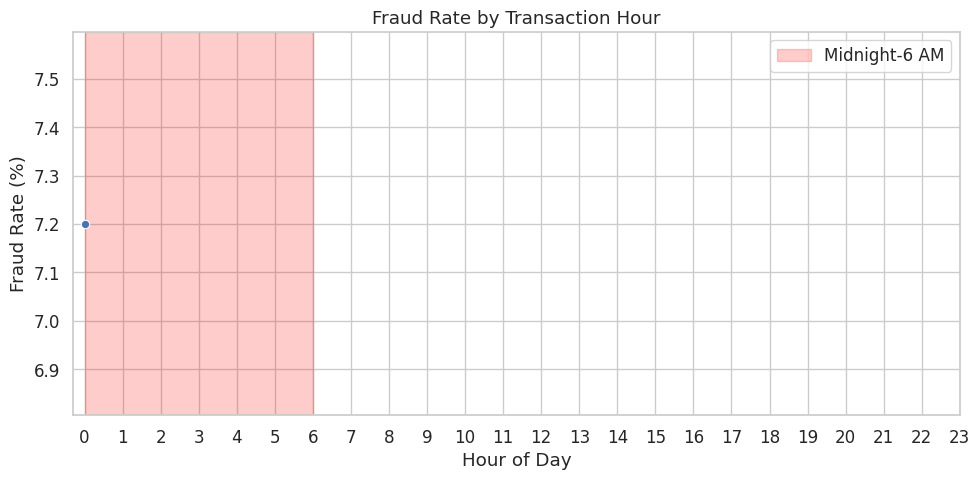


Visualization 1B: Fraud Rate by Day of Week
This bar chart shows the fraud rate for each day of the week.
It highlights whether weekends or specific weekdays have a higher incidence of fraud.


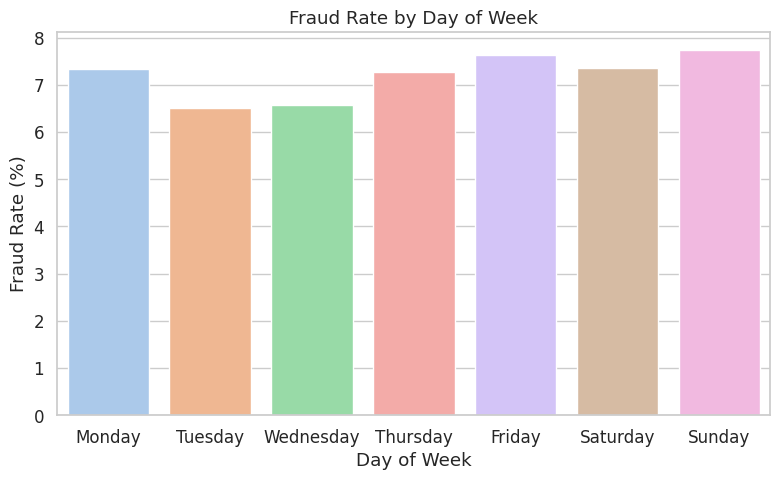


Visualization 2: Fraud Rate by Payment Channel
This bar chart compares the fraud rate between bank-level transactions and third-party methods.
A higher fraud rate on one channel indicates a vulnerability that may require additional controls.


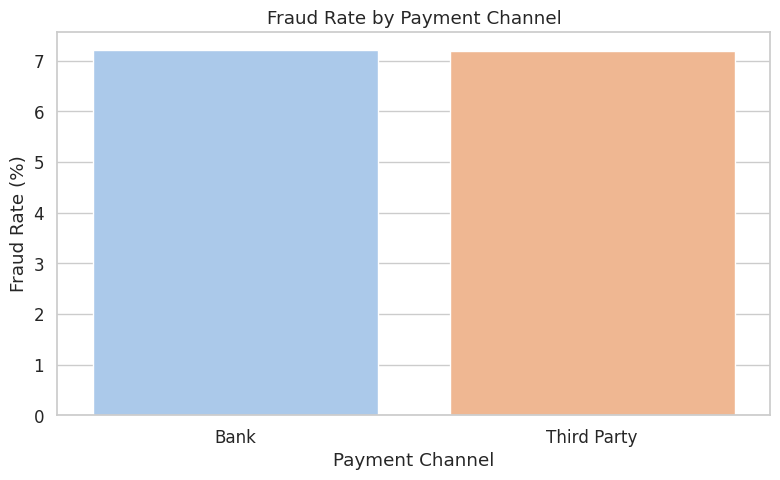


Visualization 3A: Fraud Rate by Customer Age Group
This visualization shows fraud rates across different customer age groups,
helping identify which age segments are more prone to fraud.


<ipython-input-151-3c1b3d2fb064>:171: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



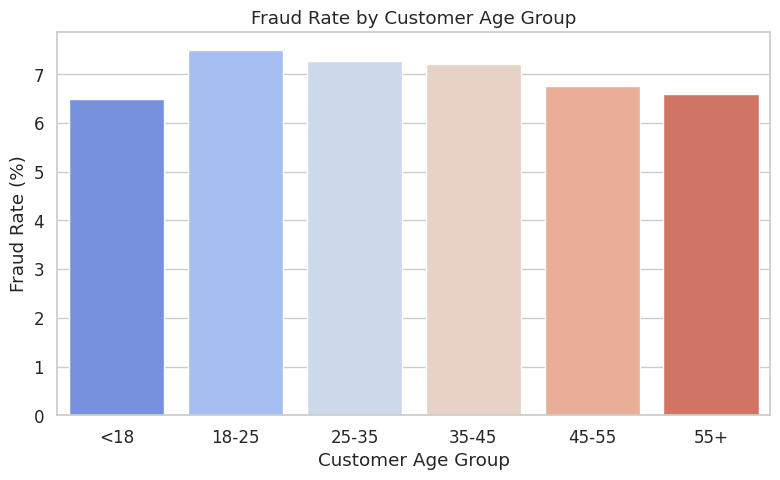


Visualization 3B: Fraud Rate by Account Age
This chart shows how fraud rates vary with account age.
New accounts (e.g., less than 30 days old) typically have a higher fraud rate.


<ipython-input-151-3c1b3d2fb064>:190: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



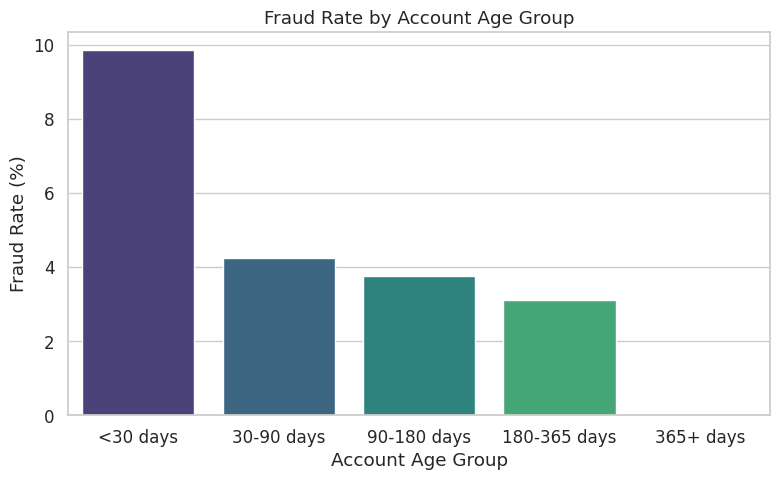


Visualization 4A: Transaction Amount vs. Account Age by Fraud Status
This scatter plot compares transaction amounts and account age, with fraud status indicated by color.
Clusters may reveal that new accounts with high transaction amounts are more prone to fraud.


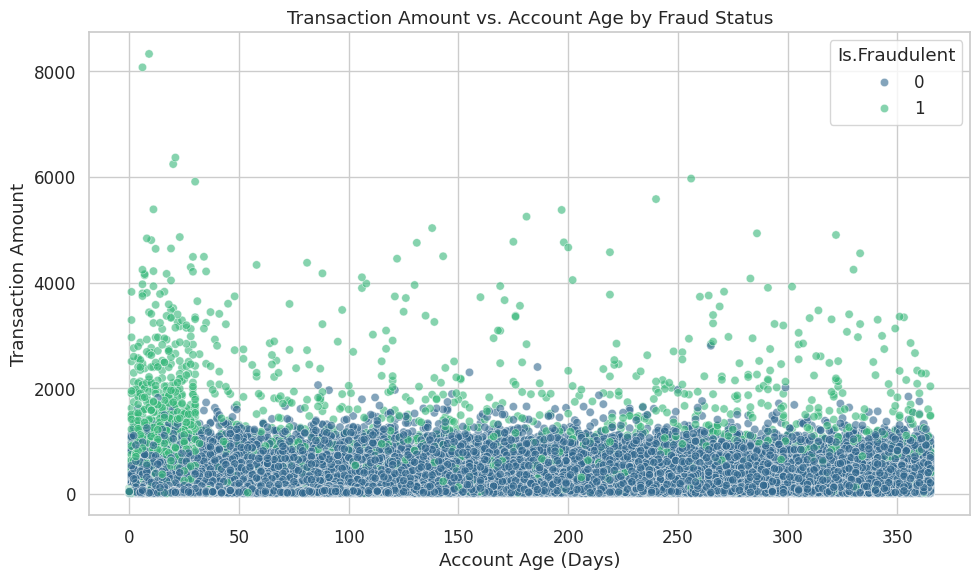


Visualization 4B: Boxplot of Transaction Amount by Fraud Status
This boxplot compares the distribution of transaction amounts between fraudulent and non-fraudulent transactions.
It can help reveal if fraud occurs predominantly at very low or very high transaction values.


<ipython-input-151-3c1b3d2fb064>:228: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




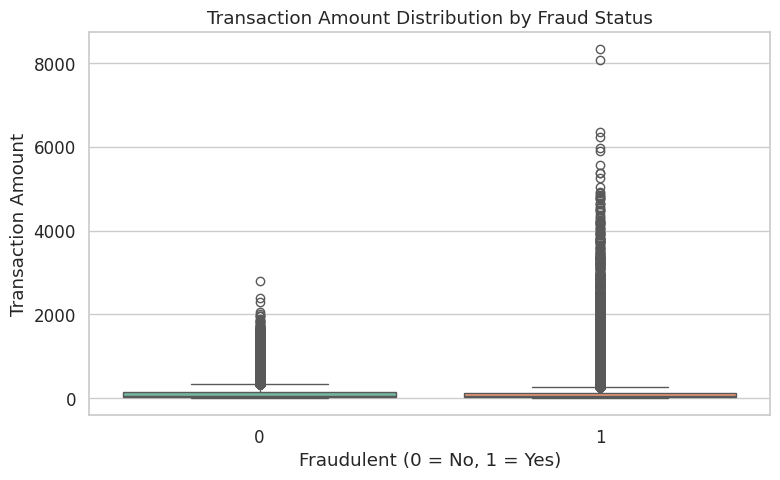


Visualization 4C: Violin Plot of Customer Age by Fraud Status
This violin plot shows the distribution of customer ages for fraudulent vs. non-fraudulent transactions.
It reveals potential demographic vulnerabilities.


<ipython-input-151-3c1b3d2fb064>:240: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




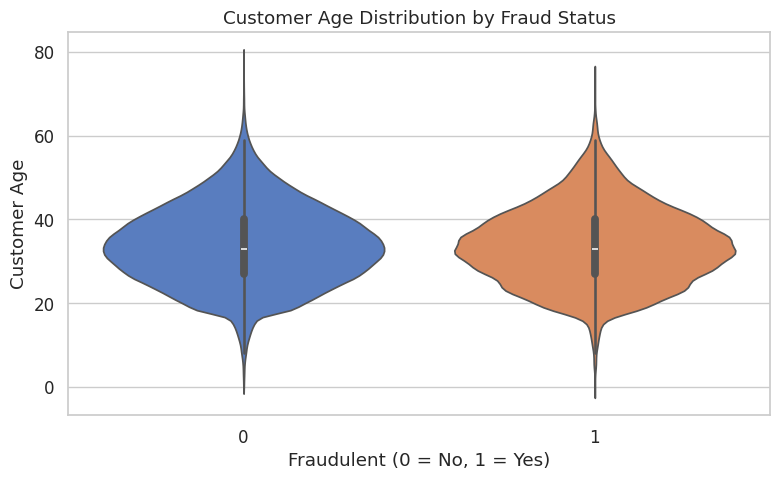


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     44544
           1       0.26      0.31      0.28      3456

    accuracy                           0.89     48000
   macro avg       0.60      0.62      0.61     48000
weighted avg       0.90      0.89      0.89     48000

----------------------------------------

Model: KNN
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     44544
           1       0.35      0.46      0.40      3456

    accuracy                           0.90     48000
   macro avg       0.65      0.70      0.67     48000
weighted avg       0.91      0.90      0.91     48000

----------------------------------------

Model: DecisionTree
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     44544
           1       0.37      0.45      0.41      3456

    accuracy                           0

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:17:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.





Model: XGBoost
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     44544
           1       0.83      0.42      0.55      3456

    accuracy                           0.95     48000
   macro avg       0.89      0.70      0.76     48000
weighted avg       0.95      0.95      0.94     48000

----------------------------------------

Updated Model Evaluation Metrics:
                    Accuracy  Precision    Recall  F1 Score   ROC-AUC
LogisticRegression  0.887813   0.261793  0.306713  0.282478  0.745388
KNN                 0.898667   0.347089  0.462384  0.396526  0.729860
DecisionTree        0.904833   0.368868  0.452546  0.406445  0.696218
RandomForest        0.951146   0.798817  0.429688  0.558796  0.767073
GradientBoosting    0.952479   0.858013  0.407407  0.552482  0.796775
XGBoost             0.951917   0.832561  0.415799  0.554612  0.794722

Model saved as fraud_detection_model.pkl
Fitting 5 folds for each of 72 candidates, totall

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
# %% [markdown]
# # Financial Fraud Detection: Storyline, Deep Insights & Proper Evaluation Preprocessing
#
# This notebook loads transaction data, performs necessary feature engineering and cleaning,
# and produces a series of visualizations that reveal actionable fraud detection insights.
#
# For each visualization, explanatory text is printed immediately before the plot so that the fraud analyst
# understands what each graph shows.
#
# In addition, the notebook splits the data into training and evaluation sets, applies SMOTE oversampling
# only to the training set, and provides separate preprocessing steps for new evaluation data (without oversampling).

# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, roc_curve)

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import pickle

# Set Plotly template and Seaborn style
pio.templates.default = "plotly_white"
sns.set(style="whitegrid", font_scale=1.1)

# %% [code]
# ---------------------------
# Data Loading & Feature Engineering
# ---------------------------
df = pd.read_csv("/content/student_dataset.csv")
print("Dataset Preview:")
print(df.head())
print("\nDataset Info:")
df.info()

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values[missing_values > 0])

# Convert Transaction.Date to datetime and extract time features
df['Transaction.Date'] = pd.to_datetime(df['Transaction.Date'], errors='coerce')
df['Transaction.Year'] = df['Transaction.Date'].dt.year
df['Transaction.Month'] = df['Transaction.Date'].dt.month
df['Transaction.Day'] = df['Transaction.Date'].dt.day
df['DayOfWeek'] = df['Transaction.Date'].dt.dayofweek  # 0=Monday, 6=Sunday

# Ensure Transaction.Hour exists
if 'Transaction.Hour' not in df.columns:
    df['Transaction.Hour'] = df['Transaction.Date'].dt.hour

# (Optional) Reconstruct datetime if needed using extracted components
temp_date = df[['Transaction.Year', 'Transaction.Month', 'Transaction.Day']].rename(
    columns={'Transaction.Year': 'year', 'Transaction.Month': 'month', 'Transaction.Day': 'day'}
)
df['Transaction.Date.Reconstructed'] = pd.to_datetime(temp_date, errors='coerce')
df['Transaction.Date'] = df['Transaction.Date.Reconstructed']

# Create a Time_Bin column (Night: 0–6, Morning: 6–12, Afternoon: 12–18, Evening: 18–24)
bins = [-1, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['Time_Bin'] = pd.cut(df['Transaction.Hour'], bins=bins, labels=labels, include_lowest=True)

# Create Payment.Channel: classify 'Bank Transfer' or 'Bank' as Bank; all others as Third Party.
df['Payment.Channel'] = df['Payment.Method'].apply(
    lambda x: 'Bank' if x.strip().lower() in ['bank transfer', 'bank'] else 'Third Party'
)

# Create a categorical variable for Transaction.Amount using quantiles (Low, Medium, High)
df['Amount.Category'] = pd.qcut(df['Transaction.Amount'], q=3, labels=['Low', 'Medium', 'High'])

# Replace negative Customer.Age values with the mean of positive ages
positive_mean_age = int(df[df['Customer.Age'] >= 0]['Customer.Age'].mean())
df.loc[df['Customer.Age'] < 0, 'Customer.Age'] = positive_mean_age
print("Customer Age statistics after correction:")
print(df['Customer.Age'].describe())
print("Negative ages remaining:", df[df['Customer.Age'] < 0].shape[0])

# %% [code]
# ---------------------------
# NEW INSIGHTFUL VISUALIZATIONS
# ---------------------------

# Section 1: Timing of Fraud

# Visualization 1A: Fraud Rate by Transaction Hour
print("\nVisualization 1A: Fraud Rate by Transaction Hour")
print("This plot shows the fraud rate for each hour of the day. The red shaded region marks midnight–6 AM,")
print("a high-risk window where the relative fraud rate is notably higher.")

hourly_stats = df.groupby(df['Transaction.Date'].dt.hour)['Is.Fraudulent'].agg(['sum','count'])
hourly_stats['fraud_rate_pct'] = (hourly_stats['sum'] / hourly_stats['count']) * 100
hourly_stats = hourly_stats.reset_index().rename(columns={'Transaction.Date': 'Hour'})

# Print summary of peak and low risk hours
peak_hours = hourly_stats.sort_values('fraud_rate_pct', ascending=False).head(2)
low_hour = hourly_stats.sort_values('fraud_rate_pct', ascending=True).head(1)
print("Peak fraud hours:\n", peak_hours[['Hour','fraud_rate_pct']])
print("Lowest fraud hour:\n", low_hour[['Hour','fraud_rate_pct']])

plt.figure(figsize=(10,5))
sns.lineplot(x='Hour', y='fraud_rate_pct', data=hourly_stats, marker='o')
plt.axvspan(0, 6, color='red', alpha=0.2, label='Midnight-6 AM')
plt.title('Fraud Rate by Transaction Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.xticks(ticks=range(0, 24), labels=range(0, 24))
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 1B: Fraud Rate by Day of Week
print("\nVisualization 1B: Fraud Rate by Day of Week")
print("This bar chart shows the fraud rate for each day of the week.")
print("It highlights whether weekends or specific weekdays have a higher incidence of fraud.")
df['DayOfWeekName'] = df['Transaction.Date'].dt.day_name()
dow_stats = df.groupby('DayOfWeekName')['Is.Fraudulent'].agg(['sum','count']).reset_index()
dow_stats['fraud_rate_pct'] = dow_stats['sum'] / dow_stats['count'] * 100
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_stats['DayOfWeekName'] = pd.Categorical(dow_stats['DayOfWeekName'], categories=order, ordered=True)
dow_stats = dow_stats.sort_values('DayOfWeekName')

plt.figure(figsize=(8,5))
sns.barplot(x='DayOfWeekName', y='fraud_rate_pct', data=dow_stats, hue='DayOfWeekName', palette='pastel')
plt.legend([],[], frameon=False)
plt.title('Fraud Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

# Section 2: Payment Method Vulnerabilities

# Visualization 2: Fraud Rate by Payment Channel
print("\nVisualization 2: Fraud Rate by Payment Channel")
print("This bar chart compares the fraud rate between bank-level transactions and third-party methods.")
print("A higher fraud rate on one channel indicates a vulnerability that may require additional controls.")
channel_stats = df.groupby('Payment.Channel')['Is.Fraudulent'].agg(['sum', 'count']).reset_index()
channel_stats['Fraud_Rate (%)'] = (channel_stats['sum'] / channel_stats['count']) * 100

plt.figure(figsize=(8,5))
sns.barplot(x='Payment.Channel', y='Fraud_Rate (%)', data=channel_stats, hue='Payment.Channel', palette='pastel')
plt.legend([],[], frameon=False)
plt.title('Fraud Rate by Payment Channel')
plt.xlabel('Payment Channel')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

# Section 3: Customer & Account Profiles

# Visualization 3A: Fraud Rate by Customer Age Group
print("\nVisualization 3A: Fraud Rate by Customer Age Group")
print("This visualization shows fraud rates across different customer age groups,")
print("helping identify which age segments are more prone to fraud.")
df['AgeGroup'] = pd.cut(df['Customer.Age'], bins=[0,18,25,35,45,55,100],
                        labels=["<18","18-25","25-35","35-45","45-55","55+"])
age_stats = df.groupby('AgeGroup')['Is.Fraudulent'].agg(['sum','count']).reset_index()
age_stats['fraud_rate_pct'] = (age_stats['sum'] / age_stats['count']) * 100

plt.figure(figsize=(8,5))
sns.barplot(x='AgeGroup', y='fraud_rate_pct', data=age_stats, hue='AgeGroup', palette='coolwarm')
plt.legend([],[], frameon=False)
plt.title('Fraud Rate by Customer Age Group')
plt.xlabel('Customer Age Group')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

# Visualization 3B: Fraud Rate by Account Age
print("\nVisualization 3B: Fraud Rate by Account Age")
print("This chart shows how fraud rates vary with account age.")
print("New accounts (e.g., less than 30 days old) typically have a higher fraud rate.")
df['AccountAgeGroup'] = pd.cut(df['Account.Age.Days'],
                               bins=[0,30,90,180,365, 10000],
                               labels=["<30 days","30-90 days","90-180 days","180-365 days","365+ days"])
acct_age_stats = df.groupby('AccountAgeGroup')['Is.Fraudulent'].agg(['sum','count']).reset_index()
acct_age_stats['fraud_rate_pct'] = (acct_age_stats['sum'] / acct_age_stats['count']) * 100

plt.figure(figsize=(8,5))
sns.barplot(x='AccountAgeGroup', y='fraud_rate_pct', data=acct_age_stats, hue='AccountAgeGroup', palette='viridis')
plt.legend([],[], frameon=False)
plt.title('Fraud Rate by Account Age Group')
plt.xlabel('Account Age Group')
plt.ylabel('Fraud Rate (%)')
plt.tight_layout()
plt.show()

# Section 4: Transaction Amount Patterns

# Visualization 4A: Scatter Plot – Transaction Amount vs. Account Age by Fraud Status
print("\nVisualization 4A: Transaction Amount vs. Account Age by Fraud Status")
print("This scatter plot compares transaction amounts and account age, with fraud status indicated by color.")
print("Clusters may reveal that new accounts with high transaction amounts are more prone to fraud.")
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Account.Age.Days',
    y='Transaction.Amount',
    hue='Is.Fraudulent',
    data=df,
    palette='viridis',
    alpha=0.6
)
plt.title('Transaction Amount vs. Account Age by Fraud Status')
plt.xlabel('Account Age (Days)')
plt.ylabel('Transaction Amount')
plt.tight_layout()
plt.show()

# Visualization 4B: Boxplot of Transaction Amount by Fraud Status
print("\nVisualization 4B: Boxplot of Transaction Amount by Fraud Status")
print("This boxplot compares the distribution of transaction amounts between fraudulent and non-fraudulent transactions.")
print("It can help reveal if fraud occurs predominantly at very low or very high transaction values.")
plt.figure(figsize=(8,5))
sns.boxplot(x='Is.Fraudulent', y='Transaction.Amount', data=df, palette='Set2')
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Fraudulent (0 = No, 1 = Yes)')
plt.ylabel('Transaction Amount')
plt.tight_layout()
plt.show()

# Visualization 4C: Violin Plot of Customer Age by Fraud Status
print("\nVisualization 4C: Violin Plot of Customer Age by Fraud Status")
print("This violin plot shows the distribution of customer ages for fraudulent vs. non-fraudulent transactions.")
print("It reveals potential demographic vulnerabilities.")
plt.figure(figsize=(8,5))
sns.violinplot(x='Is.Fraudulent', y='Customer.Age', data=df, palette='muted')
plt.title('Customer Age Distribution by Fraud Status')
plt.xlabel('Fraudulent (0 = No, 1 = Yes)')
plt.ylabel('Customer Age')
plt.tight_layout()
plt.show()

# ---------------------------
# Preprocessing for Model Training & Evaluation
# ---------------------------
# To ensure all features are numeric, we now drop columns that contain non-numeric values.
# We also encode the Payment.Channel column.
df['Payment.Channel'], _ = pd.factorize(df['Payment.Channel'])

# Build the feature set for training: choose only numeric columns.
# We use: Transaction.Amount, Customer.Age, Transaction.Hour, DayOfWeek, Account.Age.Days, and Payment.Channel.
X = df[['Transaction.Amount', 'Customer.Age', 'Transaction.Hour', 'DayOfWeek', 'Account.Age.Days', 'Payment.Channel']].copy()
y = df['Is.Fraudulent']

# Split the dataset (80% training, 20% evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Impute missing values on the training set and apply the same transformation to the evaluation set
imputer_train = SimpleImputer(strategy="mean")
X_train_imputed = imputer_train.fit_transform(X_train)
X_test_imputed = imputer_train.transform(X_test)

# Apply SMOTE oversampling only on the training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# Standardize features
scaler_std = StandardScaler()
X_train_scaled = scaler_std.fit_transform(X_train_res)
X_test_scaled = scaler_std.transform(X_test_imputed)

# ---------------------------
# Model Training & Evaluation
# ---------------------------
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1 Score': f1, 'ROC-AUC': roc_auc}

    # ---------------------------
    # Explanation of the Classification Report:
    #
    # For example, the output for LogisticRegression might look like this:
    #
    #              precision    recall  f1-score   support
    #
    #        0       0.95      0.93      0.94     44544
    #        1       0.26      0.31      0.28      3456
    #
    # - 'Precision' for a class is the proportion of predicted instances for that class that are correct.
    # - 'Recall' is the proportion of actual instances of that class that were correctly identified.
    # - 'F1-score' is the harmonic mean of precision and recall.
    # - 'Support' is the total number of actual instances in that class.
    # - 'Accuracy' is the overall fraction of correct predictions.
    # - 'Macro avg' computes the unweighted average for each metric across classes.
    # - 'Weighted avg' computes the average for each metric weighted by the number of instances in each class.
    #
    # Similar interpretation applies to the outputs for KNN, DecisionTree, etc.
    # ---------------------------

    print(f"\nModel: {name}")
    print(classification_report(y_test, y_pred))
    print("-" * 40)

results_df = pd.DataFrame(results).T
print("\nUpdated Model Evaluation Metrics:")
print(results_df)

# Save the best model (RandomForest, as an example)
best_model = models['RandomForest']
model_filename = 'fraud_detection_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nModel saved as {model_filename}")

# ---------------------------
# Hyperparameter Tuning with GridSearchCV
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train_res)
print("\nBest parameters from GridSearchCV:", grid_search.best_params_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
y_prob_best = best_rf.predict_proba(X_test_scaled)[:, 1]
print("\nClassification Report for Best RandomForest Model:")
print(classification_report(y_test, y_pred_best))
roc_auc_best = roc_auc_score(y_test, y_prob_best)
print("ROC-AUC Score for Best Model:", roc_auc_best)

# Optional: Adjust decision threshold to improve recall
threshold = 0.4
y_pred_adjusted = (y_prob_best >= threshold).astype(int)
print(f"\nClassification Report with threshold {threshold}:")
print(classification_report(y_test, y_pred_adjusted))

# Visualization: ROC Curve for Best Model
print("\nVisualization: ROC Curve for Best RandomForest Model")
print("This ROC Curve demonstrates the trade-off between the true positive rate and false positive rate,")
print("providing an overall measure of the model's performance (AUC).")
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best RandomForest Model')
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------
# Evaluation Preprocessing for New Data (Without Oversampling)
# ---------------------------
print("\nEvaluation Preprocessing for New Data:")
print("This section demonstrates how to preprocess new evaluation data without applying oversampling.")
df_eval_raw = pd.read_csv("/mnt/data/student_dataset.csv")
df_eval_raw['Transaction.Date'] = pd.to_datetime(df_eval_raw['Transaction.Date'], errors='coerce')
df_eval_raw['Transaction.Hour'] = df_eval_raw['Transaction.Date'].dt.hour
df_eval_raw['DayOfWeek'] = df_eval_raw['Transaction.Date'].dt.dayofweek
df_eval_raw['Payment.Channel'] = df_eval_raw['Payment.Method'].apply(
    lambda x: 'Bank' if x.strip().lower() in ['bank transfer', 'bank'] else 'Third Party'
)
# Factorize Payment.Channel on evaluation data as well
df_eval_raw['Payment.Channel'], _ = pd.factorize(df_eval_raw['Payment.Channel'])
df_eval_raw['Amount.Category'] = pd.qcut(df_eval_raw['Transaction.Amount'], q=3, labels=['Low', 'Medium', 'High'])
# Factorize categorical columns on evaluation data (here, just Amount.Category)
categorical_cols = ['Amount.Category']
for col in categorical_cols:
    df_eval_raw[col], _ = pd.factorize(df_eval_raw[col])
print("Evaluation data preprocessing complete. Ready for model evaluation on new data.")
